In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
river_dl = np.load("../../../Downloads/prepped2.npz", allow_pickle = True)

x = torch.from_numpy(river_dl['x_trn']).float()[-455:] # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]

ajd_matrix = river_dl['dist_matrix']
batch_size = ajd_matrix.shape[0]

x.shape, y.shape, ajd_matrix.shape

(torch.Size([455, 365, 16]), torch.Size([455, 365, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        f_seq = []
        o_seq = []
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            f_seq.append(f_t.unsqueeze(1))
            o_seq.append(o_t.unsqueeze(1))
            hidden_seq.append(h_t.unsqueeze(1))
        f_seq = torch.cat(f_seq, dim=1)
        o_seq = torch.cat(o_seq, dim=1)
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out, (f_seq, o_seq, hidden_seq)
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(16, 20, ajd_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

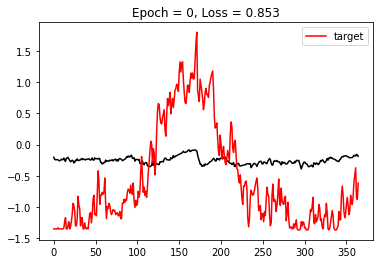

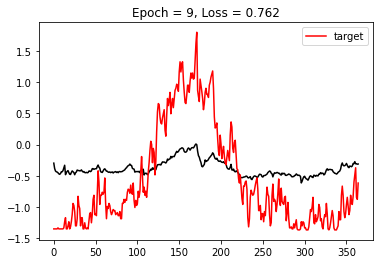

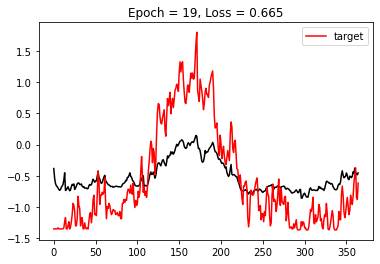

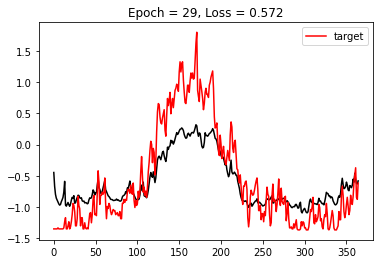

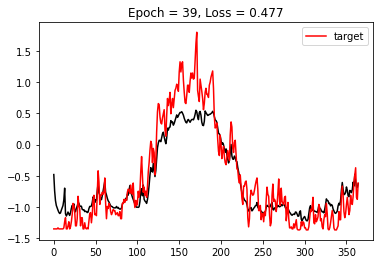

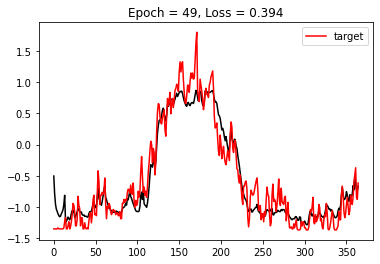

In [6]:
epochs = 50

for i in range(epochs):
    out, (f_ls, o_ls, h_ls) = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Apply XAI and visualize

In [7]:
f_ls = f_ls.detach()
o_ls = o_ls.detach()
h_ls = h_ls.detach()

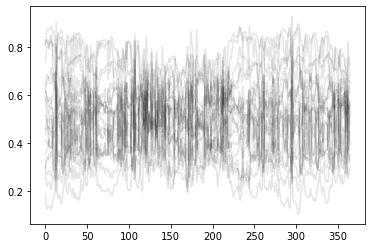

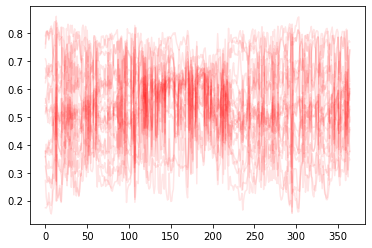

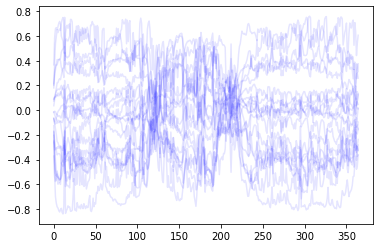

In [8]:
plt.plot(f_ls[0, :], color = 'black', alpha = 0.1)
plt.pause(0.001)
plt.plot(o_ls[0, :], color = 'red', alpha = 0.1)
plt.pause(0.001)
plt.plot(h_ls[0, :], color = 'blue', alpha = 0.1);

In [9]:
def calc_additive_decomp(f_ls, o_ls, h_ls, date_limit):

    h_T = torch.zeros((h_ls.shape[0], date_limit, h_ls.shape[2]))

    prop_retained_T = torch.zeros((h_ls.shape[0], date_limit, h_ls.shape[2]))
    info_gained_T = torch.zeros((h_ls.shape[0], date_limit, h_ls.shape[2]))
    info_contributed_T = torch.zeros((h_ls.shape[0], date_limit, 1))

    for t in range(1, date_limit):

        # Product for retention from k = t+1 to T
        for k in range(t+1, h_T.shape[1]):
            # f_{k} * o_{k} / o_{k-1}
            value = (f_ls[:, [k]]*o_ls[:, [k]]) / o_ls[:, [k-1]]
            if k == t+1:
                proportion_retained = value
            else:
                proportion_retained = value*proportion_retained
        prop_retained_T[:, [t], :] = proportion_retained

        # Equations for initial gain
        # intermed_value = f_{t} * o_{t} / o_{t-1}]
        intermed_value = (f_ls[:, [t]]*o_ls[:, [t]]) / o_ls[:, [t-1]]
        # h_{t} - value * h_{t-1}
        info_gained = h_ls[:, [t]] - (intermed_value*h_ls[:, [t-1]])
        info_gained_T[:, [t], :] = info_gained

        # Summation for actual contribution
        last_value = proportion_retained*info_gained
        if t == 1:
            info_contributed = last_value
        else:
            info_contributed = info_contributed + last_value

        # Application of weight matrix
        for batch_i in range(h_ls.shape[0]):
            with torch.no_grad():
                info_contributed_T[batch_i, t, 0] = nn.functional.linear(info_contributed[batch_i],
                                                                         model.dense.weight)
                
    return(prop_retained_T, info_gained_T, info_contributed_T)

In [10]:
prop_retained_T, info_gained_T, info_contributed_T = calc_additive_decomp(f_ls, o_ls, h_ls, 365)

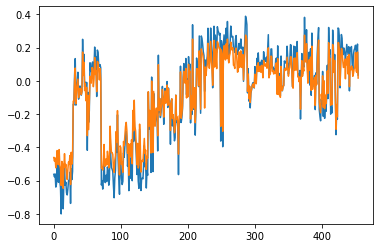

In [11]:
plt.plot(nn.functional.linear(h_ls[:, -1], model.dense.weight).detach()) # h_{t} times the dense layers weights
plt.plot(info_contributed_T[:, -1]); # information gain = h_{t}, times the dense layer weights

# Same visualizations produced for Jiang et al work

In [12]:
def plot_paper_figures(batch_i, t_end):
    fig, ax = plt.subplots(4, 2, figsize = (12, 16))
    
    ax[0, 1].set_visible(False)
    ax[0, 0].plot(out[batch_i, :t_end].detach(), color = 'black', label = 'Prediction')
    ax[0, 0].plot(y[batch_i, :t_end], color = 'red', label = 'Target')
    ax[0, 0].legend()

    ax[1, 0].plot(info_gained_T[batch_i], color = 'black', alpha = 0.1)
    ax[1, 0].set_title('Information initially gained')
    ax[1, 1].plot(info_gained_T[batch_i, -25:], color = 'black', alpha = 0.1)
    ax[1, 1].set_title('Information initially gained | last 25 observations')

    ax[2, 0].plot(prop_retained_T[batch_i], color = 'black', alpha = 0.1)
    ax[2, 0].set_title('Proportion to be retained')
    ax[2, 1].plot(prop_retained_T[batch_i, -25:], color = 'black', alpha = 0.1)
    ax[2, 1].set_title('Proportion to be retained | last 25 observations')

    ax[3, 0].bar(range(info_contributed_T[batch_i].shape[0]),
                 info_contributed_T[batch_i],
                 color = 'red', edgecolor = 'black')
    ax[3, 0].set_title('Information actually contributed')
    ax[3, 1].bar(range(info_contributed_T[batch_i, -25:].shape[0]),
                 info_contributed_T[batch_i, -25:],
                 color = 'red', edgecolor = 'black')
    ax[3, 1].set_title('Information actually contributed | last 25 observations');

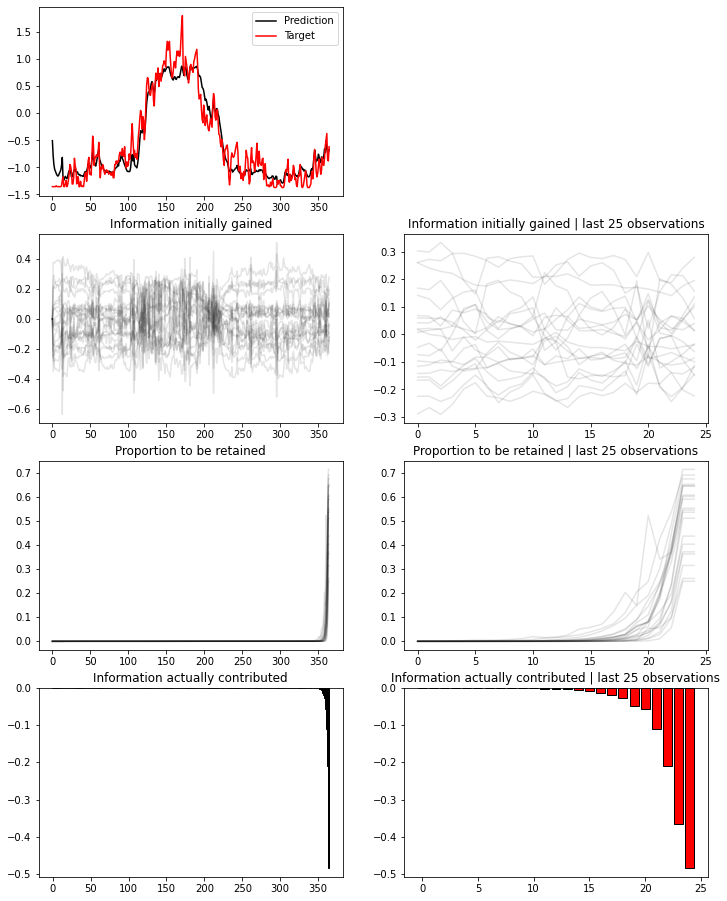

In [13]:
batch_i = 1 
plot_paper_figures(batch_i, 365)

# Change the date of interest: summer

Instead of looking at the last output, let's only calculate the values with the upper date limit as 180 - making the interprations be for a summer date rather than a winter date

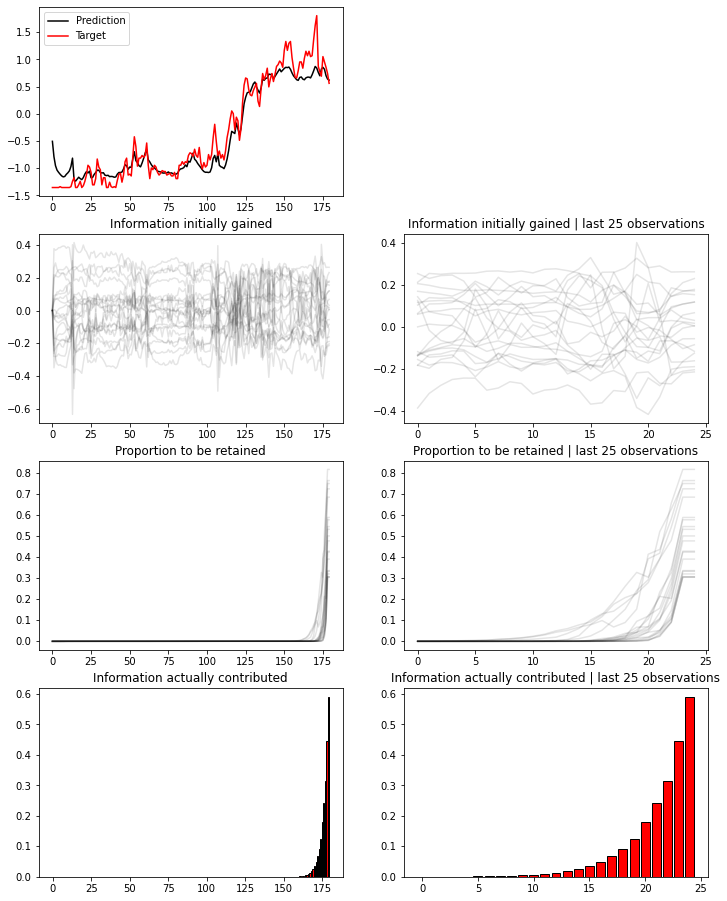

In [14]:
batch_i = 1 
date_limit = 180

prop_retained_T, info_gained_T, info_contributed_T = calc_additive_decomp(f_ls, o_ls, h_ls, date_limit)
plot_paper_figures(batch_i, date_limit)

# Change the date of interest: fall

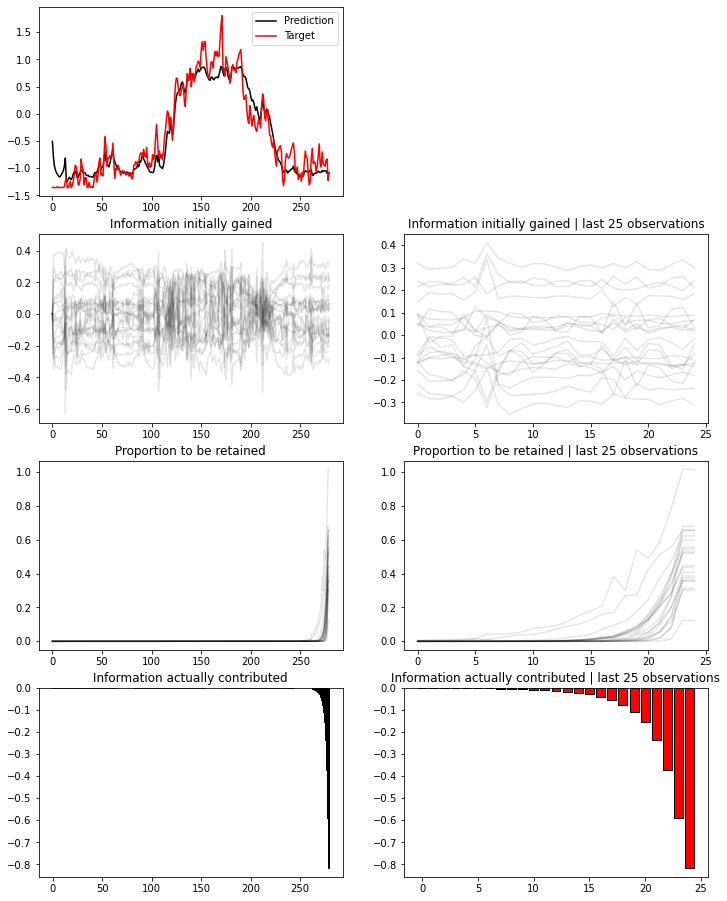

In [15]:
batch_i = 1 
date_limit = 280

prop_retained_T, info_gained_T, info_contributed_T = calc_additive_decomp(f_ls, o_ls, h_ls, date_limit)
plot_paper_figures(batch_i, date_limit)

# Change the date of interest: spring

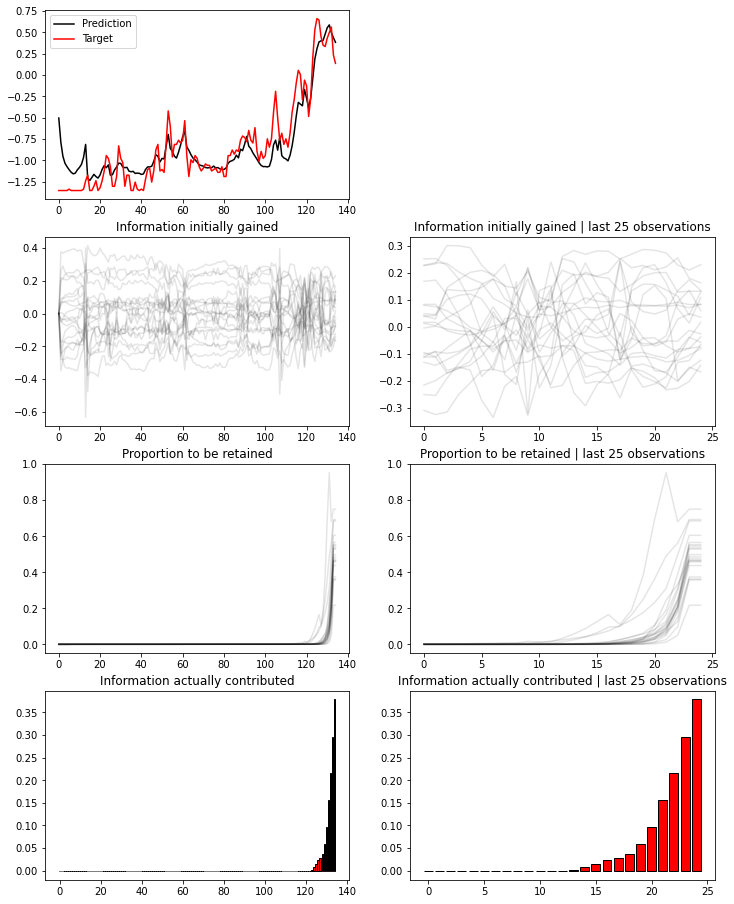

In [16]:
batch_i = 1 
date_limit = 135

prop_retained_T, info_gained_T, info_contributed_T = calc_additive_decomp(f_ls, o_ls, h_ls, date_limit)
plot_paper_figures(batch_i, date_limit)